In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# For getting and transforming the MNIST dataset
from torchvision import datasets
from torchvision import transforms

### Settings

In [2]:
RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 5
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(DEVICE)

cuda


### Getting the dataset

In [3]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

print(f"The length of train dataset: {len(train_dataset)}")

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

print(f"The length of test dataset: {len(test_dataset)}")

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          pin_memory=True,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False,
                         pin_memory=True,
                         num_workers=4)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

The length of train dataset: 60000
The length of test dataset: 10000
Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


### Model Definition

In [4]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        ### 1st hidden layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden)
        nn.init.kaiming_uniform_(self.linear_1.weight, mode='fan_in', nonlinearity='relu') # initializing the weights 
        nn.init.zeros_(self.linear_1.bias)                        # initializing the bias 

        ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden, num_classes)
        nn.init.normal_(self.linear_out.weight, mean=0.0, std=0.1)   # initializing the weights
        nn.init.zeros_(self.linear_out.bias)                         # initializing the bias 
        
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        #probas = torch.softmax(logits, dim=1)
        return logits#, probas

### Model initialization

In [5]:
torch.manual_seed(RANDOM_SEED)

model = MLP(num_features=28*28,
            num_hidden=100,
            num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-8)

In [6]:
print(model)

MLP(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)


In [7]:
total_params = sum(p.numel() for p in model.parameters())

print(total_params)

79510


### Helper Functions

In [8]:
# Helper function to compute loss

def compute_loss(net, data_loader):
    net.eval() # evaluation mode
    total_loss, total_samples = 0.0, 0
    with torch.no_grad(): # no gradient tracking
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net(features)
            loss = F.cross_entropy(logits, targets, reduction="sum")  # sum, not mean
            total_loss += loss.item()
            total_samples += targets.size(0)
    return total_loss / total_samples

# Helper function to compute accuracy

def compute_accuracy(net, data_loader):
    net.eval()  # evaluation mode
    correct_pred, num_examples = 0, 0
    with torch.no_grad():  # no gradient tracking
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)

            logits = net(features)
            predicted_labels = torch.argmax(logits, dim=1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item()

    return correct_pred / num_examples * 100

### Training

In [9]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking = True)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
       
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        minibatch_cost.append(cost.item())
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost.item()))
        
    cost = compute_loss(model, train_loader)
    epoch_cost.append(cost)
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/600 | Cost: 2.5509
Epoch: 001/005 | Batch 050/600 | Cost: 0.2874
Epoch: 001/005 | Batch 100/600 | Cost: 0.2760
Epoch: 001/005 | Batch 150/600 | Cost: 0.2537
Epoch: 001/005 | Batch 200/600 | Cost: 0.1472
Epoch: 001/005 | Batch 250/600 | Cost: 0.2129
Epoch: 001/005 | Batch 300/600 | Cost: 0.2077
Epoch: 001/005 | Batch 350/600 | Cost: 0.2113
Epoch: 001/005 | Batch 400/600 | Cost: 0.1785
Epoch: 001/005 | Batch 450/600 | Cost: 0.0999
Epoch: 001/005 | Batch 500/600 | Cost: 0.2053
Epoch: 001/005 | Batch 550/600 | Cost: 0.1715
Epoch: 001/005 Train Cost: 0.1258
Time elapsed: 0.24 min
Epoch: 002/005 | Batch 000/600 | Cost: 0.1767
Epoch: 002/005 | Batch 050/600 | Cost: 0.1582
Epoch: 002/005 | Batch 100/600 | Cost: 0.0414
Epoch: 002/005 | Batch 150/600 | Cost: 0.0688
Epoch: 002/005 | Batch 200/600 | Cost: 0.1638
Epoch: 002/005 | Batch 250/600 | Cost: 0.1261
Epoch: 002/005 | Batch 300/600 | Cost: 0.1481
Epoch: 002/005 | Batch 350/600 | Cost: 0.1959
Epoch: 002/005 | Batch 

### Plotting training loss

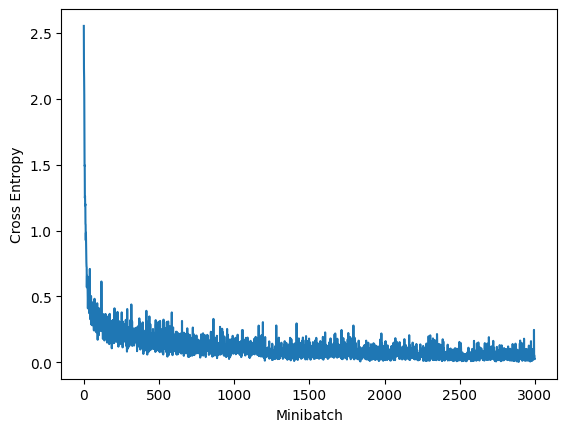

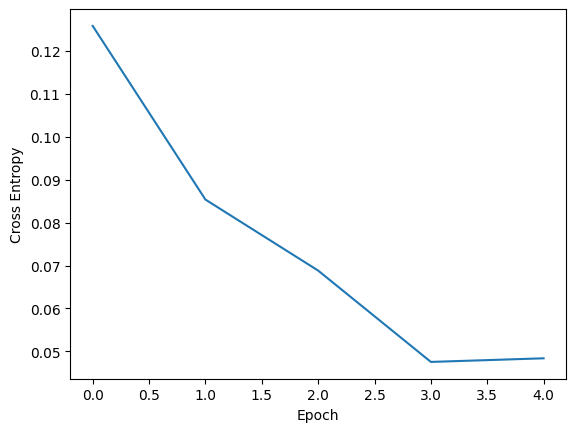

In [10]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [11]:
print(f"Training Accuracy: {compute_accuracy(model, train_loader):.2f}%")
print(f"Test Accuracy: {compute_accuracy(model, test_loader):.2f}%")

Training Accuracy: 98.52%
Test Accuracy: 97.00%


In [12]:
def show_examples(model, data_loader):

    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            targets = targets.to(DEVICE)
            logits = model(features.view(-1,28*28).to(DEVICE))
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)

    nhwc_img = np.transpose(features.cpu().numpy(), axes=(0, 2, 3, 1))
    nhw_img = np.squeeze(nhwc_img, axis=3)

    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(nhw_img[idx], cmap='binary')
        ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
        ax.axison = False

    plt.tight_layout()
    plt.show()

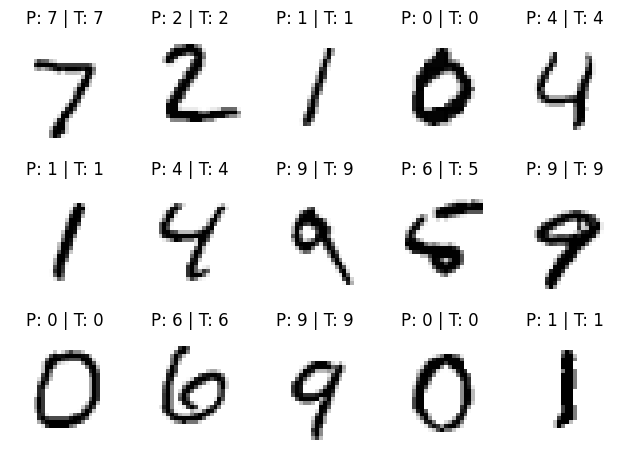

In [13]:
show_examples(model=model, data_loader=test_loader)

In [14]:
if DEVICE == "cuda":
    torch.cuda.empty_cache()    # Release GPU Memory 